In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from analysis_by_plot import draw_floorplan
from utils import spl

In [2]:
n_trial = 50
ls_var = 'x', 'y'

In [3]:
record_dir = '/home/yihelu/miniconda3/envs/igibson/lib/python3.8/site-packages/igibson/yihe/records/'
experiment_id = 'point-goal-random-50' 

data_dir = os.path.join(record_dir, experiment_id)

model_names = 'GoalFollower', 'CXonly', 'MB2ONbilateral'
ls_color = 'grb'

In [4]:
total_task = 300

task = {'scene_name': [], 'shortest_dist': [], 'shortest_path': []}
performance = {}
for model_name in model_names:
    performance[model_name] = {'collision': [], 'spl': []}

for ti, trial_id in enumerate(np.sort(os.listdir(data_dir))[:total_task]):
    trial_dir = os.path.join(data_dir, trial_id)
    
    alldata = {}
    for model_name in model_names:
        alldata[model_name] = {'steer': [], 'xy': [], 'force': []}
        
    for trial in range(n_trial):
        for model_name in model_names:
            if trial > 0 and model_name in ('CXonly', 'GoalFollower'):
                continue
            data_name = 'Freight_{}_trial_{}_record.npz'.format(model_name, trial)
            data = np.load(os.path.join(trial_dir, data_name), allow_pickle=True)
            
            alldata[model_name]['steer'].append(data['extra'][()]['steer_mode'])
            alldata[model_name]['xy'].append([data['x'], data['y']])
            alldata[model_name]['force'].append(data['f'])

    scene_name = data['scene_name']
    pos_goal = data['pos_goal'][:2]
    shortest_dist = data['optimal_route'][1]
    
    for model_name in model_names:
#         n_collision = [np.count_nonzero(steer == 'reflex') for steer in alldata[model_name]['steer']]
        n_collision = [np.count_nonzero(force > 100) for force in alldata[model_name]['force']]

        val_spl = [spl(np.transpose(path), pos_goal, shortest_dist) for path in alldata[model_name]['xy']]
        performance[model_name]['collision'].append(n_collision)
        performance[model_name]['spl'].append(val_spl)

        if model_name == model_names[0]:
            task['scene_name'].append(scene_name)
            task['shortest_dist'].append(shortest_dist)

In [5]:
spl_summary = {'20th': [], 'first': [], 'last': [], 'mean': [], 'best': [], 'sorted': [], 'time2best': [], 'time2saturation': []}
success_summary = {'20th': [], 'first': [], 'last': [], 'mean': [], 'best': [], 'sorted': [], 'time2best': [], 'time2saturation': []}
collision_summary = {'20th': [], 'first': [], 'last': [], 'mean': [], 'best': [], 'sorted': [], 'time2best': [], 'time2saturation': []}

for model_name in ('GoalFollower', 'CXonly'):

    spl_cx = np.transpose(performance[model_name]['spl'])[0]

#     spl_summary[model_name] = np.mean(spl_cx, axis=1)
#     success_summary[model_name] = (np.any(spl_cx, axis=1)).astype(int)
#     collision_summary[model_name] = np.mean(performance[model_name]['collision'], axis=1)
    spl_summary[model_name] = spl_cx
    success_summary[model_name] = (spl_cx > 0).astype(int)
    collision_summary[model_name] = np.transpose(performance[model_name]['collision'])[0]

In [60]:
n_trial = 20

model_name = 'MB2ONbilateral'

spl_mbcx = np.array(performance[model_name]['spl'])[:, :n_trial]
col_mbcx = np.array(performance[model_name]['collision'])[:, :n_trial]

spl_summary['first'] = spl_mbcx[:, 0]
spl_summary['last'] = spl_mbcx[:, -1]
spl_summary['mean'] = np.mean(spl_mbcx, axis=1)
spl_summary['best'] = np.max(spl_mbcx, axis=1)
spl_summary['time2best'] = np.argmax(spl_mbcx, axis=1)

spl_mod = np.hstack((spl_mbcx, np.full((spl_mbcx.shape[0], 1), -1)))
diff = np.diff(spl_mod, axis=1)
spl_summary['time2refine'] = np.argmax(diff < 0, axis=1)
spl_summary['refine'] = spl_mod[np.arange(spl_mod.shape[0]), spl_summary['time2refine']]

success_summary['refine'] = (spl_summary['refine'] > 0).astype(int)
collision_summary['refine'] = col_mbcx[np.arange(spl_mod.shape[0]), spl_summary['time2refine']]


success_summary['first'] = (spl_mbcx[:, 0] > 0).astype(int)
success_summary['last'] = (spl_mbcx[:, -1] > 0).astype(int)
success_summary['mean'] = np.mean((spl_mbcx > 0).astype(int), axis=1)
success_summary['best'] = (np.any(spl_mbcx, axis=1)).astype(int)

collision_summary['first'] = col_mbcx[:, 0]
collision_summary['last'] = col_mbcx[:, -1]
collision_summary['mean'] = np.mean(col_mbcx, axis=1)
collision_summary['best'] = np.diag(col_mbcx[:, spl_summary['time2best']])

In [61]:
def spl_histogram(ax, spl, success):
    counts, bins = np.histogram(100 - np.array(spl) * 100, bins=np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1]) * 100)
    ax.barh(bins[:-1] - 10, np.flip(counts), height=10, align='edge')
    ax.axhline(np.mean(spl) * 100, color='k')
    print(np.mean(success), np.mean(spl))
    return np.mean(spl)

0.69 0.6899449290910781
0.6233333333333333 0.6131324544444217
0.6566666666666666 0.6420669684046683
0.7433333333333333 0.7374406006086854
0.7433333333333333 0.740453260318871
0.7 0.686182207156749


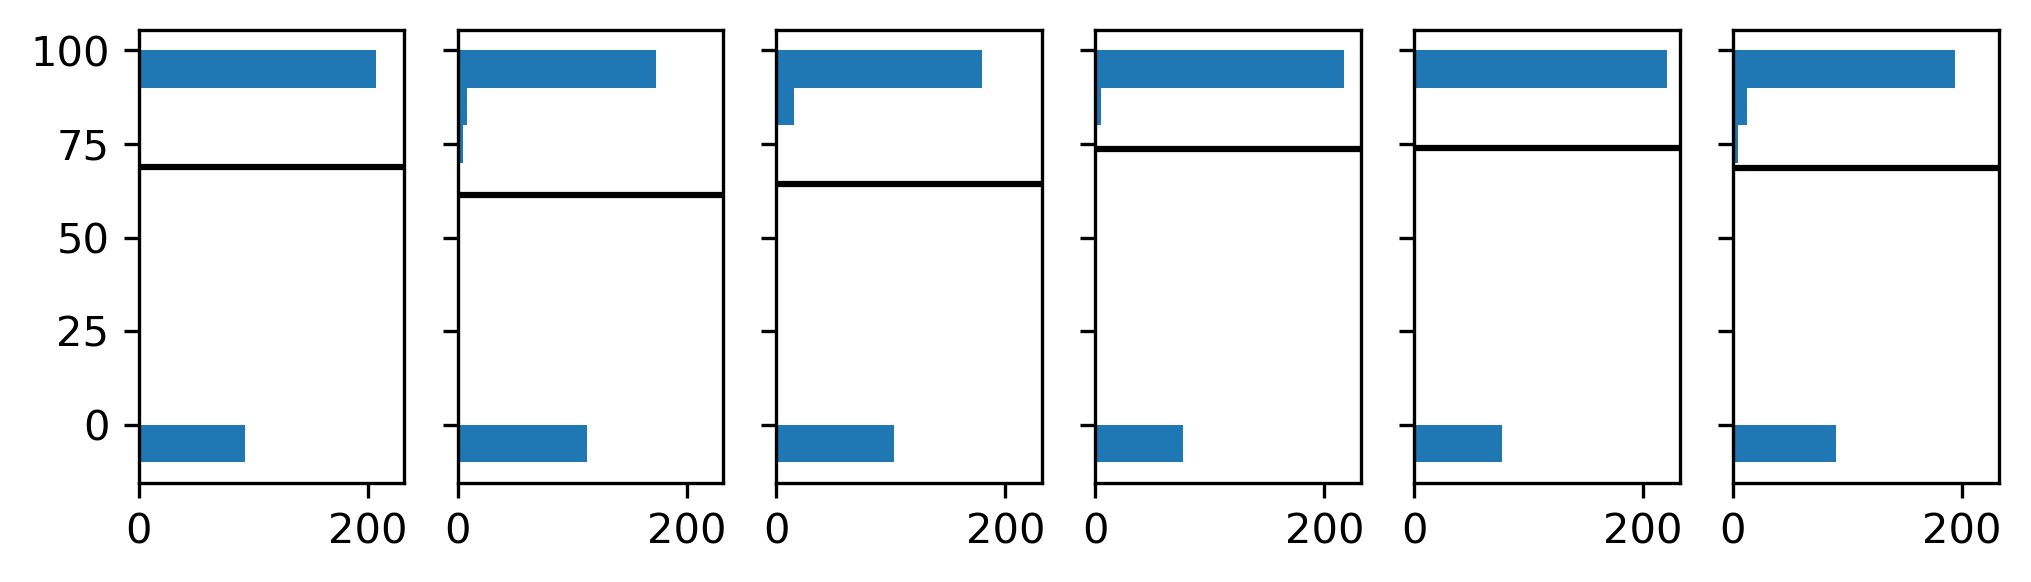

In [62]:
fig, axes = plt.subplots(1, 6, figsize=(8, 2), sharex=True, sharey=True, dpi=300)

n_success = []
mean_spl = []
spl_gcv = []
col_all = []

for ax, key in zip(axes, ('GoalFollower', 'CXonly', 'first', 'refine', 'best', 'last')):
    mspl = spl_histogram(ax, spl_summary[key], success_summary[key])
    mean_spl.append(mspl)
    n_success.append(np.count_nonzero(spl_summary[key]))
    spl_gcv.append(spl_summary[key])
    col_all.append(collision_summary[key])
    
col_all = np.array(col_all)

In [63]:
def waterfall(ax, success_data, x0=0.5):
    for x, (left, right) in enumerate(zip(success_data[:-1], success_data[1:])):
        diff = right - left
        n_pos = np.count_nonzero(diff > 0)
        n_neg = np.count_nonzero(diff < 0)
        for pm, data, c, base in zip((1, -1), (n_pos, n_neg), 'gr', (left, right)):
            xx = x0 + x - pm *0
            yy = np.count_nonzero(left)
            if data != 0:
                ax.bar(xx, data * pm, bottom=yy, facecolor='none', edgecolor=c, width=0.35, ls='dotted')
            # else:
            #     ax.plot([xx - 0.1, xx + 0.1], [yy, yy], color=c, lw=0.9, ls='dotted')

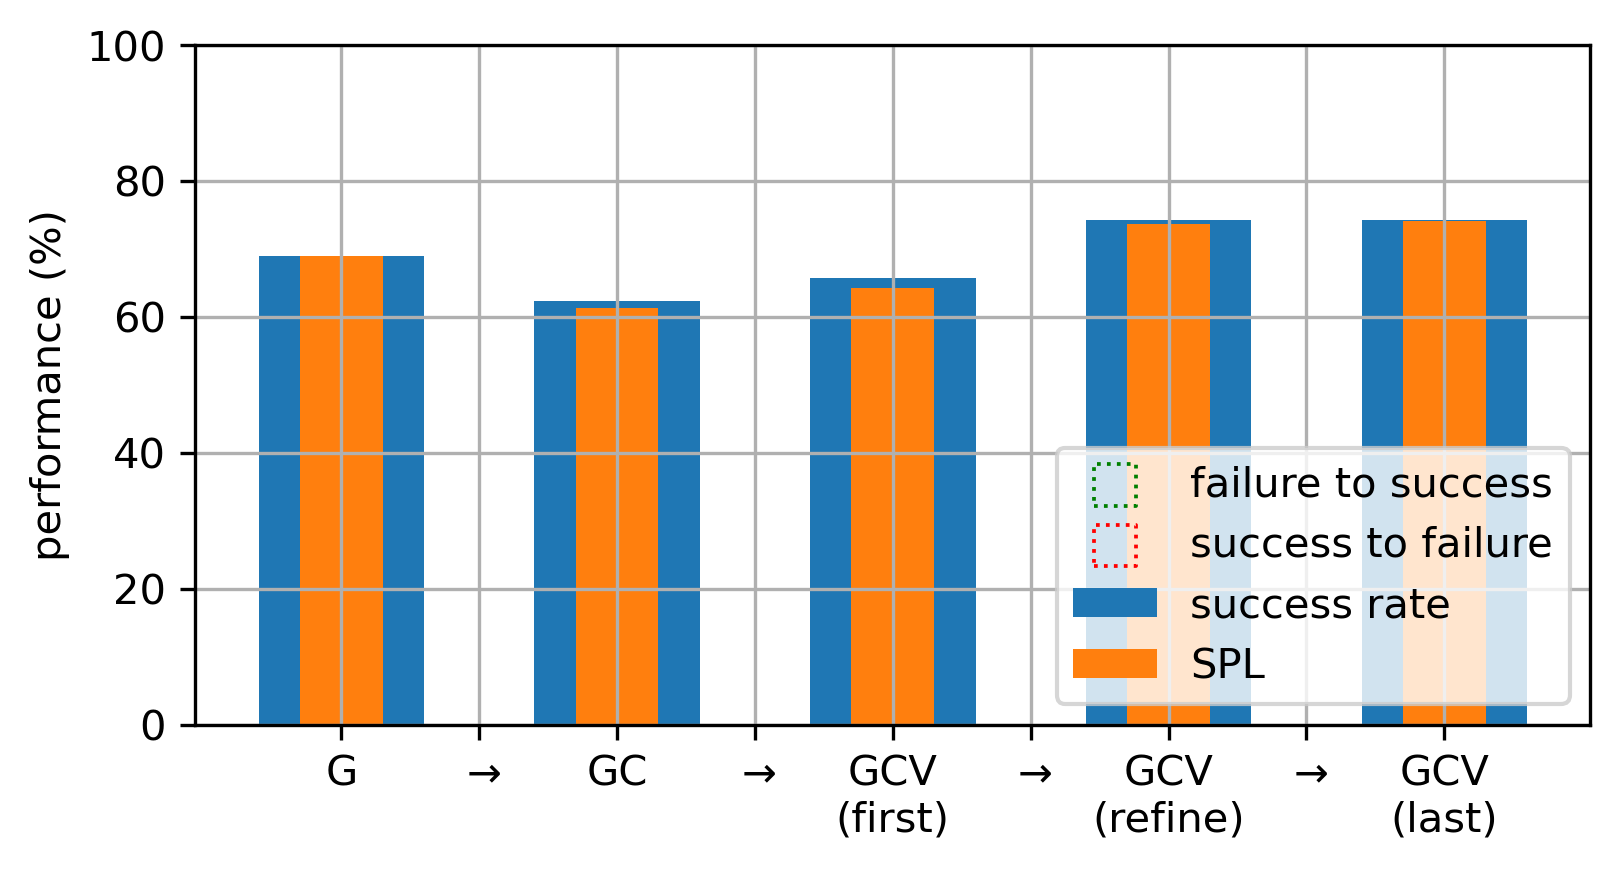

In [64]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=300)

ax.bar(np.arange(5), np.divide(n_success[:-1], total_task) * 100, width=0.6, label='success rate')
ax.bar(np.arange(5), np.array(mean_spl[:-1]) * 100, width=0.3, label='SPL')

waterfall(ax, (np.array(spl_gcv)[:-1] > 0).astype(int))
ax.scatter([], [], s=100, marker='s', facecolor='none', edgecolor='g', lw=0.9, ls='dotted', label='failure to success')
ax.scatter([], [], s=100, marker='s', facecolor='none', edgecolor='r', lw=0.9, ls='dotted', label='success to failure')

model_names = 'G', 'GC', 'GCV\n(first)', 'GCV\n(best)', 'GCV\n(last)', 'GCV\n(mean)'
ax.set_ylabel('performance (%)')
ax.set_ylim(top=100)
ax.legend(loc=4)


ax.set_xticks(np.arange(0, 4.1, 0.5),
              ['G', r'$\rightarrow$', 'GC', r'$\rightarrow$', 'GCV\n(first)', r'$\rightarrow$', 'GCV\n(refine)', r'$\rightarrow$', 'GCV\n(last)'])# np.insert(model_names[:-1], [1, 2, 3, 4], r'$\rightarrow$'))


ax.grid()

# plt.savefig("gibson-performance.pdf", format="pdf", bbox_inches="tight", dpi=300)

In [65]:
col_all.shape

(6, 300)

[115.42         7.23666667   6.69666667   4.63666667   5.01
   4.97333333]


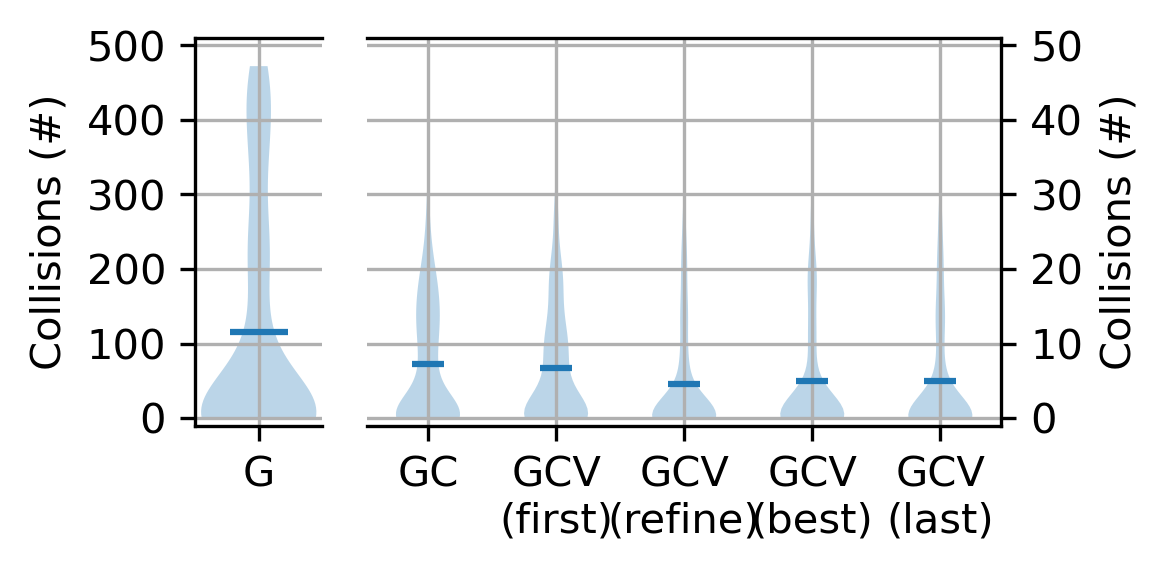

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(4, 2), gridspec_kw={'width_ratios': [1, 5]}, dpi=300)
print(np.mean(col_all, axis=1))
axes[0].violinplot(col_all[0], showextrema=False, showmeans=True)
axes[1].violinplot(col_all[1:].T, showextrema=False, showmeans=True)

for ax in axes:
    ax.grid()
    
axes[0].set_xticks([1], ['G'])
axes[1].set_xticks(np.arange(1, 5.5, 1), ['GC', 'GCV\n(first)', 'GCV\n(refine)', 'GCV\n(best)', 'GCV\n(last)'])
    
axes[0].set_ylim(-10, 510)
axes[0].set_yticks(np.arange(0, 501, 100))
axes[1].set_ylim(-1, 51)
axes[1].set_yticks(np.arange(0, 51, 10))



axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()

for ax in axes:
    ax.set_ylabel('Collisions (#)')

fig.tight_layout()

plt.savefig("igibson-collision.pdf", format="pdf", bbox_inches="tight", dpi=300)

In [67]:
spl_gcv = np.multiply(spl_gcv, 100)


In [79]:
hardtaskid = np.nonzero(spl_gcv[1] == 0)[0]
n_hard = hardtaskid.size

In [80]:
print(np.mean((spl_gcv > 0).astype(int) * 100, axis=-1))
print(np.mean((spl_gcv[:, hardtaskid] > 0).astype(int) * 100, axis=-1))

[69.         62.33333333 65.66666667 74.33333333 70.        ]
[20.3539823   0.         14.15929204 33.62831858 26.54867257]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (6,) and arg 1 with shape (5,).

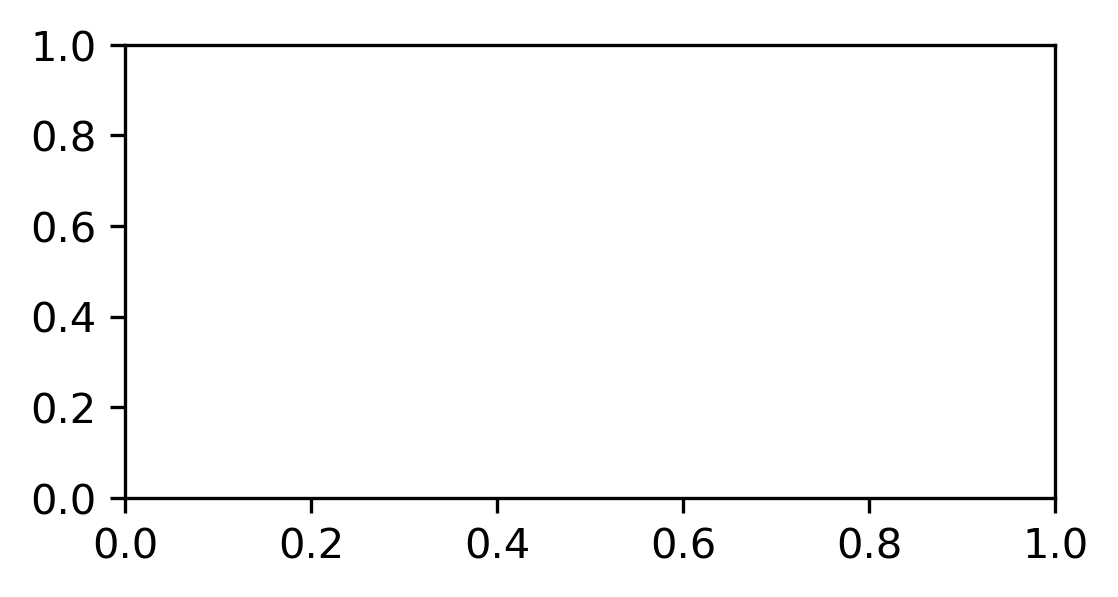

In [81]:
fig, ax = plt.subplots(figsize=(4, 2), dpi=300)


ax.bar(np.arange(6) - 0.2, np.mean((spl_gcv > 0).astype(int) * 100, axis=-1), 
       width=0.35, fill=False, edgecolor='tab:blue', lw=0.8)
ax.violinplot(spl_gcv.T, positions=np.arange(6) - 0.2,
              showextrema=False, showmeans=True)

ax.bar(np.arange(6) + 0.2, np.mean((spl_gcv[:, hardtaskid] > 0).astype(int) * 100, axis=-1), 
       width=0.35, fill=False, edgecolor='tab:orange', lw=0.8)
ax.violinplot(spl_gcv[:, hardtaskid].T, positions=np.arange(6) + 0.2,
              showextrema=False, showmeans=True)

ax.set_ylim(0, 100)
ax.set_xticks(np.arange(0, 5.5, 0.5), ['G', r'$\rightarrow$', 'GC', r'$\rightarrow$', 'GCV\n(first)', r'$\rightarrow$', 'GCV\n(refine)', r'$\rightarrow$', 'GCV\n(best)', r'$\rightarrow$', 'GCV\n(last)'])
ax.set_ylabel('Performance (%)')
# ax.set_title('$N={}, M={}$'.format(total_task, n_hard), loc='right')
ax.grid()

ax.scatter([], [], marker='None', label='shapes:')
ax.scatter([], [], label='Success rate', facecolor='none', linewidth=0.8, edgecolor='k', marker='s', s=100)
ax.scatter([], [], label='SPL', color='k', alpha=0.3, marker='s', s=100)
ax.plot([], [], label='SPL mean', color='k', lw=2)

ax.scatter([], [], marker='None', label='colors:')
ax.fill_between([], [], [], [], color='tab:blue', alpha=0.3, label='all episodes')
ax.fill_between([], [], [], [], color='tab:orange', alpha=0.3, label='hard episodes')


ax.legend(ncol=2, loc='upper right', bbox_to_anchor=(1,-0.3))

plt.savefig("igibson-performance.pdf", format="pdf", bbox_inches="tight", dpi=300)

In [75]:
spl_gcv = spl_gcv[[0, 1, 2, 3, 5]]
col_all = col_all[[0, 1, 2, 3, 5]]

[69.         62.33333333 65.66666667 74.33333333 70.        ]
[68.99449291 61.31324544 64.20669684 73.74406006 68.61822072]


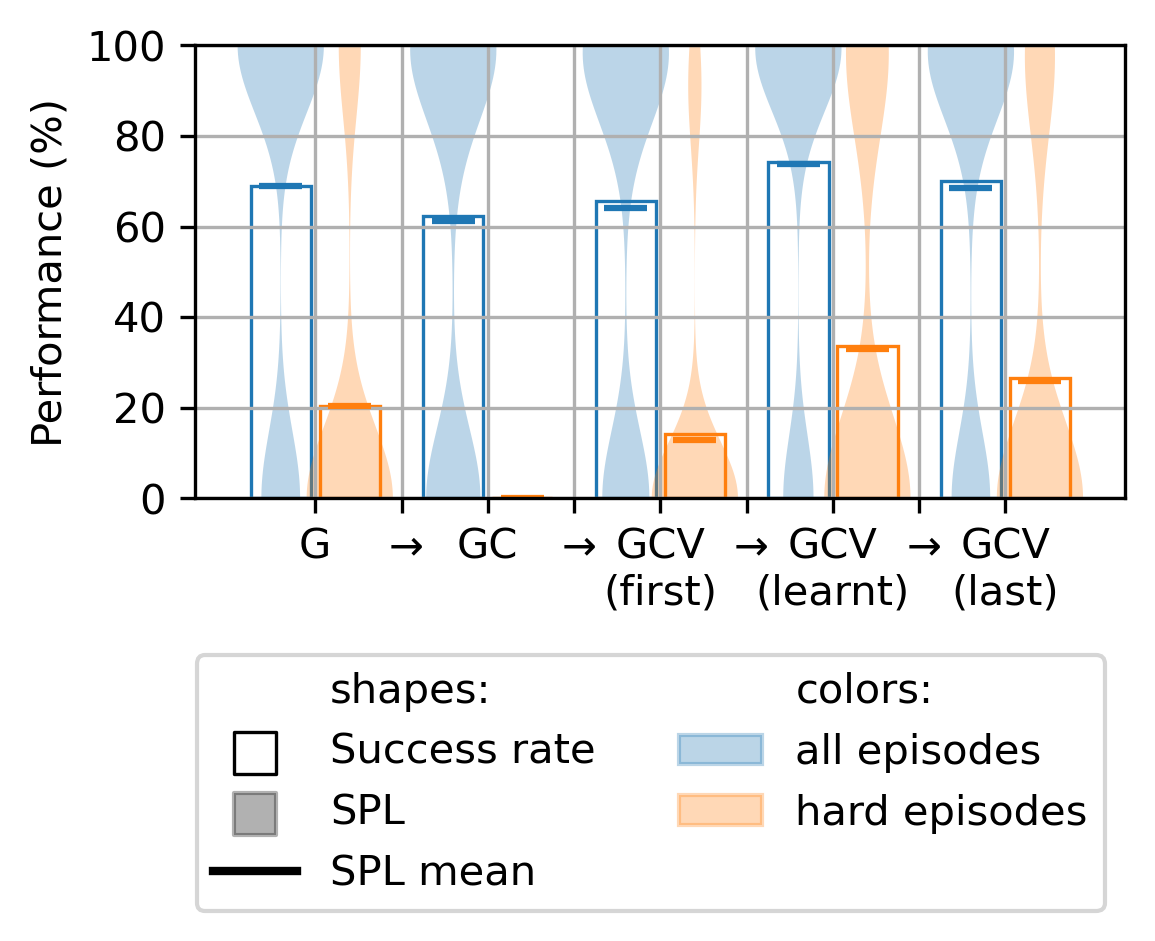

In [82]:
fig, ax = plt.subplots(figsize=(4, 2), dpi=300)
xx = np.arange(len(spl_gcv))

print(np.mean((spl_gcv > 0).astype(int) * 100, axis=1))
print(np.mean(spl_gcv, axis=1))
ax.bar(xx - 0.2, np.mean((spl_gcv > 0).astype(int) * 100, axis=-1), 
       width=0.35, fill=False, edgecolor='tab:blue', lw=0.8)
ax.violinplot(spl_gcv.T, positions=xx - 0.2,
              showextrema=False, showmeans=True)

ax.bar(xx + 0.2, np.mean((spl_gcv[:, hardtaskid] > 0).astype(int) * 100, axis=-1), 
       width=0.35, fill=False, edgecolor='tab:orange', lw=0.8)
ax.violinplot(spl_gcv[:, hardtaskid].T, positions=xx + 0.2,
              showextrema=False, showmeans=True)

ax.set_ylim(0, 100)
ax.set_xticks(np.arange(0, 4.5, 0.5), ['G', r'$\rightarrow$', 'GC', r'$\rightarrow$', 'GCV\n(first)', r'$\rightarrow$', 'GCV\n(learnt)', r'$\rightarrow$', 'GCV\n(last)'])
ax.set_ylabel('Performance (%)')
# ax.set_title('$N={}, M={}$'.format(total_task, n_hard), loc='right')
ax.grid()

ax.scatter([], [], marker='None', label='shapes:')
ax.scatter([], [], label='Success rate', facecolor='none', linewidth=0.8, edgecolor='k', marker='s', s=100)
ax.scatter([], [], label='SPL', color='k', alpha=0.3, marker='s', s=100)
ax.plot([], [], label='SPL mean', color='k', lw=2)

ax.scatter([], [], marker='None', label='colors:')
ax.fill_between([], [], [], [], color='tab:blue', alpha=0.3, label='all episodes')
ax.fill_between([], [], [], [], color='tab:orange', alpha=0.3, label='hard episodes')


ax.legend(ncol=2, loc='upper right', bbox_to_anchor=(1,-0.3))

plt.savefig("igibson-performance.pdf", format="pdf", bbox_inches="tight", dpi=300)

[115.42         7.23666667   6.69666667   4.63666667   4.97333333]


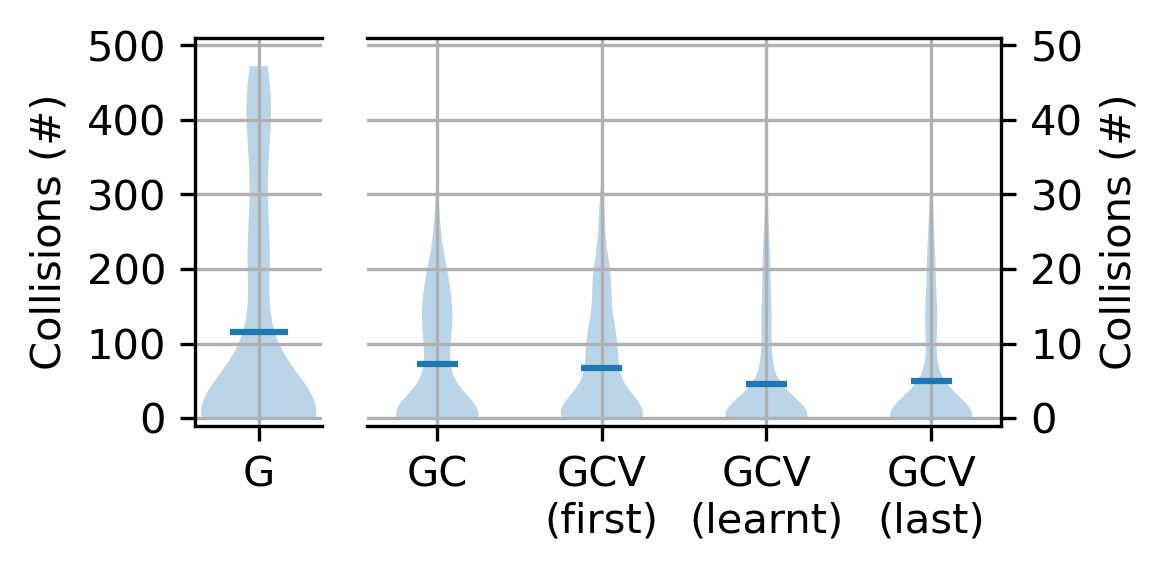

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(4, 2), gridspec_kw={'width_ratios': [1, 5]}, dpi=300)
print(np.mean(col_all, axis=1))
axes[0].violinplot(col_all[0], showextrema=False, showmeans=True)
axes[1].violinplot(col_all[1:].T, showextrema=False, showmeans=True)

for ax in axes:
    ax.grid()
    
axes[0].set_xticks([1], ['G'])
axes[1].set_xticks(np.arange(1, 4.5, 1), ['GC', 'GCV\n(first)', 'GCV\n(learnt)', 'GCV\n(last)'])
    
axes[0].set_ylim(-10, 510)
axes[0].set_yticks(np.arange(0, 501, 100))
axes[1].set_ylim(-1, 51)
axes[1].set_yticks(np.arange(0, 51, 10))



axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()

for ax in axes:
    ax.set_ylabel('Collisions (#)')

fig.tight_layout()

plt.savefig("igibson-collision.pdf", format="pdf", bbox_inches="tight", dpi=300)

In [19]:
model_names = 'GoalFollower', 'CXonly', 'MB2ONbilateral'


trial_id = np.random.choice(os.listdir(data_dir))
print(trial_id)
trial_dir = os.path.join(data_dir, trial_id)

alldata = {}
for model_name in model_names:
    alldata[model_name] = {'steer': [], 'xy': []}

for trial in range(n_trial)[:1]:
    for model_name in model_names:
        data_name = 'Freight_{}_trial_{}_record.npz'.format(model_name, trial)
        data = np.load(os.path.join(trial_dir, data_name), allow_pickle=True)

        alldata[model_name]['steer'].append(data['extra'][()]['steer_mode'])
        alldata[model_name]['xy'].append([data['x'], data['y']])
        
    scene_name = data['scene_name']

sim_20250116_151509_random


(-7.612853214467188, 1.3263263435460568)

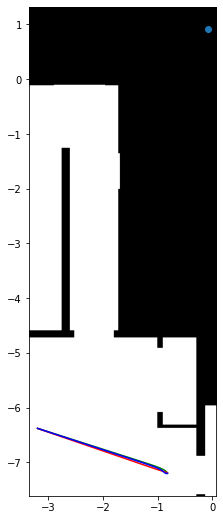

In [20]:
fig, ax = plt.subplots(figsize=(18, 9))
ax.scatter(*pos_goal)
xlim, ylim = [np.inf, -np.inf], [np.inf, -np.inf]
for model_name, c in zip(model_names, ls_color):
    ax.plot(*alldata[model_name]['xy'][0], c=c)
    (xmin, xmax), (ymin, ymax) = ax.get_xlim(), ax.get_ylim()
    xlim = np.minimum(xlim[0], xmin), np.maximum(xlim[1], xmax)
    ylim = np.minimum(ylim[0], ymin), np.maximum(ylim[1], ymax)
    

floorplan = '/home/yihelu/miniconda3/envs/igibson/lib/python3.8/site-packages/igibson/data/ig_dataset/scenes/{}/layout/floor_trav_no_door_0.png'.format(scene_name)
draw_floorplan(ax, floorplan, 0.01)    
ax.set_xlim(xlim)
ax.set_ylim(ylim)

(-7.636675990847257, 1.3274607614689171)

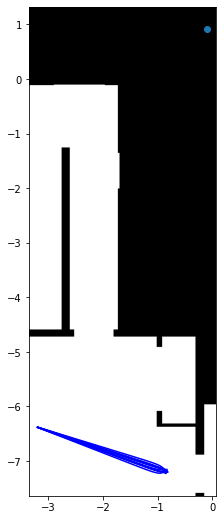

In [21]:
fig, ax = plt.subplots(figsize=(18, 9))
ax.scatter(*pos_goal)
xlim, ylim = [np.inf, -np.inf], [np.inf, -np.inf]
model_name = 'MB2ONbilateral'
for i in range(n_trial//5):
    trial = i * 5
    data_name = 'Freight_{}_trial_{}_record.npz'.format(model_name, trial)
    data = np.load(os.path.join(trial_dir, data_name), allow_pickle=True)
    ax.plot(data['x'], data['y'], c=c)
    (xmin, xmax), (ymin, ymax) = ax.get_xlim(), ax.get_ylim()
    xlim = np.minimum(xlim[0], xmin), np.maximum(xlim[1], xmax)
    ylim = np.minimum(ylim[0], ymin), np.maximum(ylim[1], ymax)
    

floorplan = '/home/yihelu/miniconda3/envs/igibson/lib/python3.8/site-packages/igibson/data/ig_dataset/scenes/{}/layout/floor_trav_no_door_0.png'.format(scene_name)
draw_floorplan(ax, floorplan, 0.01)    
ax.set_xlim(xlim)
ax.set_ylim(ylim)